In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [3]:
df_target = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')


In [24]:
df_test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
df_train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')

In [5]:
df_test

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [6]:
print( 
'''texts:{} 

keywords: {} 

locations: {}'''.format(df_test['text'].unique()[:5],
                     df_test['keyword'].unique()[:5],
                        df_test['location'].unique()[:5])
     )

texts:['Just happened a terrible car crash'
 'Heard about #earthquake is different cities, stay safe everyone.'
 'there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all'
 'Apocalypse lighting. #Spokane #wildfires'
 'Typhoon Soudelor kills 28 in China and Taiwan'] 

keywords: [nan 'ablaze' 'accident' 'aftershock' 'airplane%20accident'] 

locations: [nan 'London' "Niall's place | SAF 12 SQUAD |" 'NIGERIA' 'Live On Webcam']


In [7]:
import re as re
import string
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

# Applying the cleaning function to both test and training datasets
df_train['text'] = df_train['text'].apply(lambda x: clean_text(x))
df_test['text'] = df_test['text'].apply(lambda x: clean_text(x))

# Let's take a look at the updated text
df_train['text'].head()

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3     people receive wildfires evacuation orders in...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

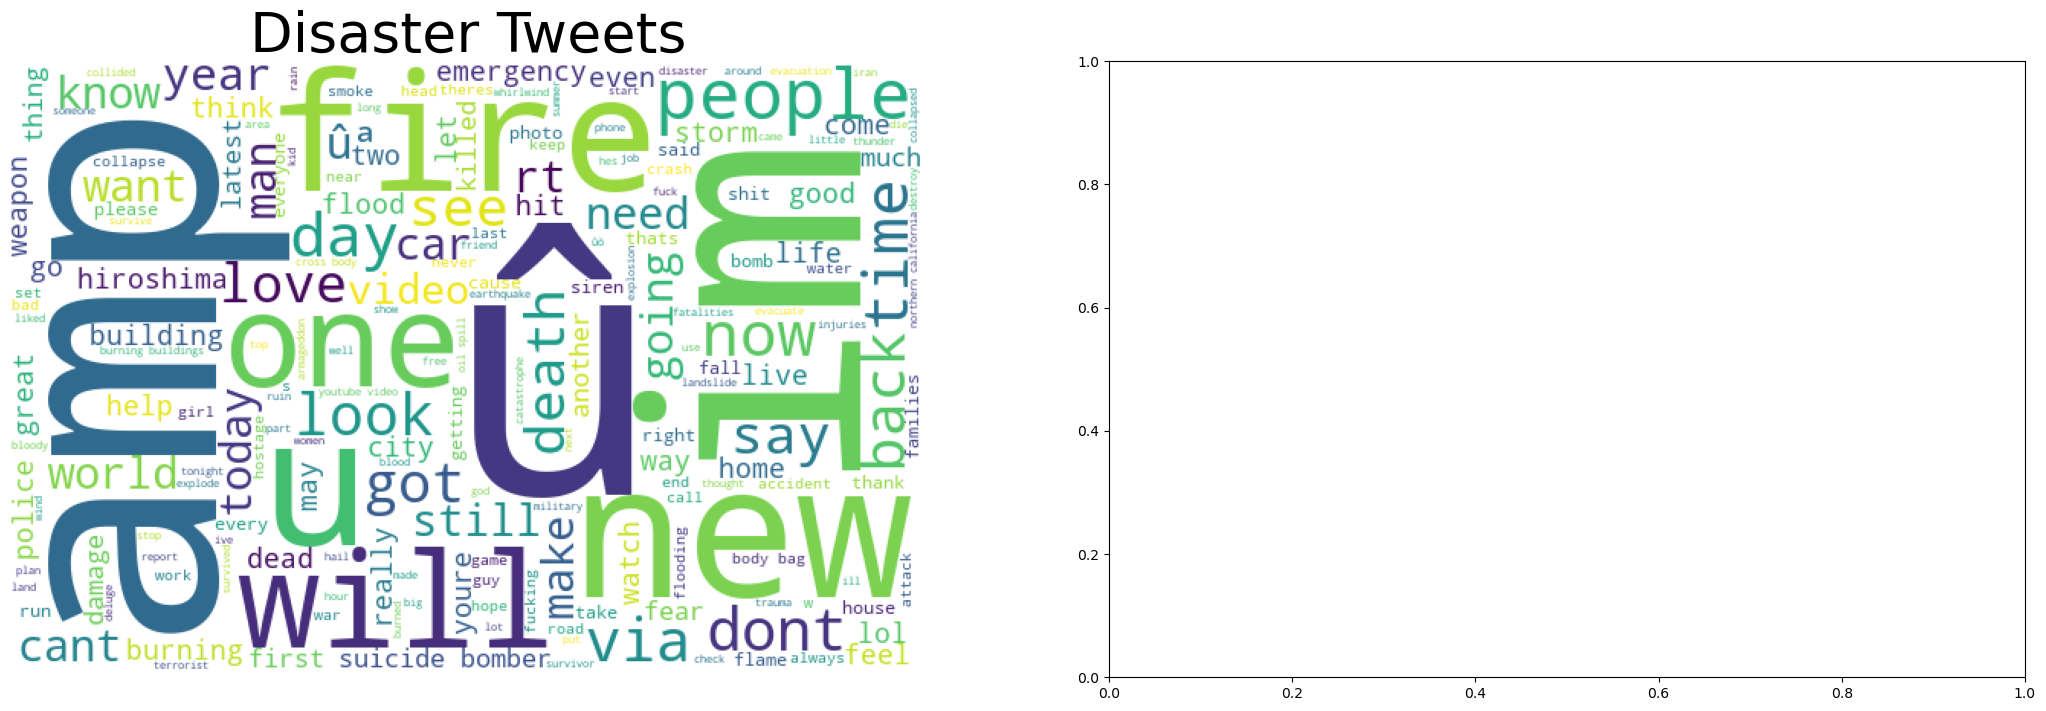

In [8]:
from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[26, 8])

disaster_tweets_tokens_test = []
for val in df_test.text:
    tokens = val.split()
    disaster_tweets_tokens_test = disaster_tweets_tokens_test + tokens
disaster_tweets_tokens_test = " ".join(disaster_tweets_tokens_test)+" "
wordcloud1 = WordCloud(background_color='white',
                        stopwords = set(STOPWORDS),
                        width=600,
                        height=400).generate(disaster_tweets_tokens_test)
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Disaster Tweets',fontsize=40);

disaster_tweets_tokens_train = []
for val in df_train.text:
    tokens = val.split()
    disaster_tweets_tokens_train = disaster_tweets_tokens_train + tokens
disaster_tweets_tokens_train = " ".join(disaster_tweets_tokens_train)+" "
wordcloud1 = WordCloud(background_color='white',
                        stopwords = set(STOPWORDS),
                        width=600,
                        height=400).generate(disaster_tweets_tokens_train)
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Disaster Tweets',fontsize=40);

In [19]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

vectorizer = CountVectorizer(ngram_range=(1,2)
#                              , stop_words = set(STOPWORDS)
                            )
X_test = vectorizer.fit_transform(df_test['text'])
X_train = vectorizer.transform(df_train['text'])

y_train = np.array(df_train['target'])

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  % sorted(inconsistent)


In [20]:
vectorizer.get_feature_names_out()


array(['aapatwork', 'aaron', 'aaron dannybmiller', ..., 'ûówe work',
       'ûówere', 'ûówere worse'], dtype=object)

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import GridSearchCV
parameters = {"C":[0.001,0.01,0.1,1,10]}
clf = LogisticRegression(solver = 'liblinear')
scores = cross_val_score(clf,X_train, y_train, cv = 4,scoring='f1')
print(np.mean(scores))

0.5987583447261954


In [22]:
# parameters = {"C":[0.001,0.01,0.1, 0.5, 1,10,100]}
# clf = LogisticRegression(solver = 'liblinear')
# clf = GridSearchCV(clf,                    # model
#                    param_grid = parameters,   # hyperparameters
#                    scoring='f1',        # metric for scoring
#                    cv=10)                     # number of folds
# scores = cross_val_score(clf,X_train, y_train, cv = 4,scoring='f1')
# print(np.mean(scores))

0.5960806404076704


In [37]:
tdif_vectorizer = TfidfVectorizer(ngram_range=(1,1))
X_tdif_train = tdif_vectorizer.fit_transform(df_train['text'])
X_tdif_test = tdif_vectorizer.fit(df_test['text']) 
clf = LogisticRegression(solver = 'liblinear')
scores = cross_val_score(clf,X_tdif_train, y_train, cv = 4,scoring='f1')
print(np.mean(scores))



0.6453153466515217
